In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from Brownian_test_func import *

info = pd.read_csv("data/info.csv")
Count = pd.read_csv("data/st_count.csv", index_col = 0)
Count = Count.loc[:,info.iloc[:,0]]
symbol_all = Count.index

loc = pd.DataFrame({'x':info['x'],
                    'y':info['y']})


In [2]:
adata_data = sc.AnnData(Count.T)
adata_data.var_names = Count.index
adata_data.obs_names = Count.columns
adata_data.obs['celltype'] = info['Region'].values
symbol = adata_data.var_names

sc.pp.filter_genes(adata_data, min_cells=20)
sc.pp.normalize_total(adata_data, inplace=True)
sc.pp.log1p(adata_data)

symbol_sel = adata_data.var_names

## Testing for spatial location

In [3]:
pathway_df = find_pathway(symbol_sel.values, symbol.values)

pathway_df.to_csv('PDAC_related_pathway.csv', index=False)

file_name = 'PDAC_loc_res.csv'

brownian_testing(pathway_df, loc.values, adata_data, file_name, n_perm = 199)

path_res = pd.read_csv(file_name)

path_res = path_res.sort_values(by='dcor', ascending=False)

path_res = path_res.reset_index(drop=True)

R[write to console]: Loading required package: AnnotationDbi

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


R[write to console]: Loading required package: Biobase

R[write to console]: Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()

[1] "The first element does not contain 'ENS'."


R[write to console]: 'select()' returned 1:many mapping between keys and columns

R[write to console]: 'select()' returned 1:many mapping between keys and columns



Now conduct brownian test for 3498 Pathways


100%|████████████████████████████████████████████████| 3497/3497 [02:12<00:00, 26.37it/s]


In [4]:
path_res

,ID,name,n_gene,pval,dcov,dcor
0,GO:0045104,intermediate filament cytoskeleton organization,25,0.005,1.046357,0.598623
1,GO:0045103,intermediate filament-based process,25,0.005,1.046357,0.598623
2,GO:0045109,intermediate filament organization,13,0.005,1.063902,0.593388
3,GO:0030307,positive regulation of cell growth,66,0.005,0.975874,0.590806
4,GO:0045927,positive regulation of growth,92,0.005,0.957056,0.585728
...,...,...,...,...,...,...
3492,GO:0006506,GPI anchor biosynthetic process,11,0.085,0.168531,0.154235
3493,GO:0060412,ventricular septum morphogenesis,13,0.050,0.163711,0.153840
3494,GO:0045738,negative regulation of DNA repair,13,0.015,0.210746,0.152218
3495,GO:0018904,ether metabolic process,11,0.110,0.141877,0.151559


## Analyze and Visualize each pathway

In [9]:
show_path = 'GO:0045104'

show_info = pathway_df.iloc[np.where(pathway_df['GOBPID']==show_path)[0],:]

gene_str = show_info['name'].tolist()

gene_str = gene_str[0].strip("'")

gene_str = gene_str.split(', ')

print(len(gene_str))

25


In [11]:
gene_str[i]

'FAM83H'

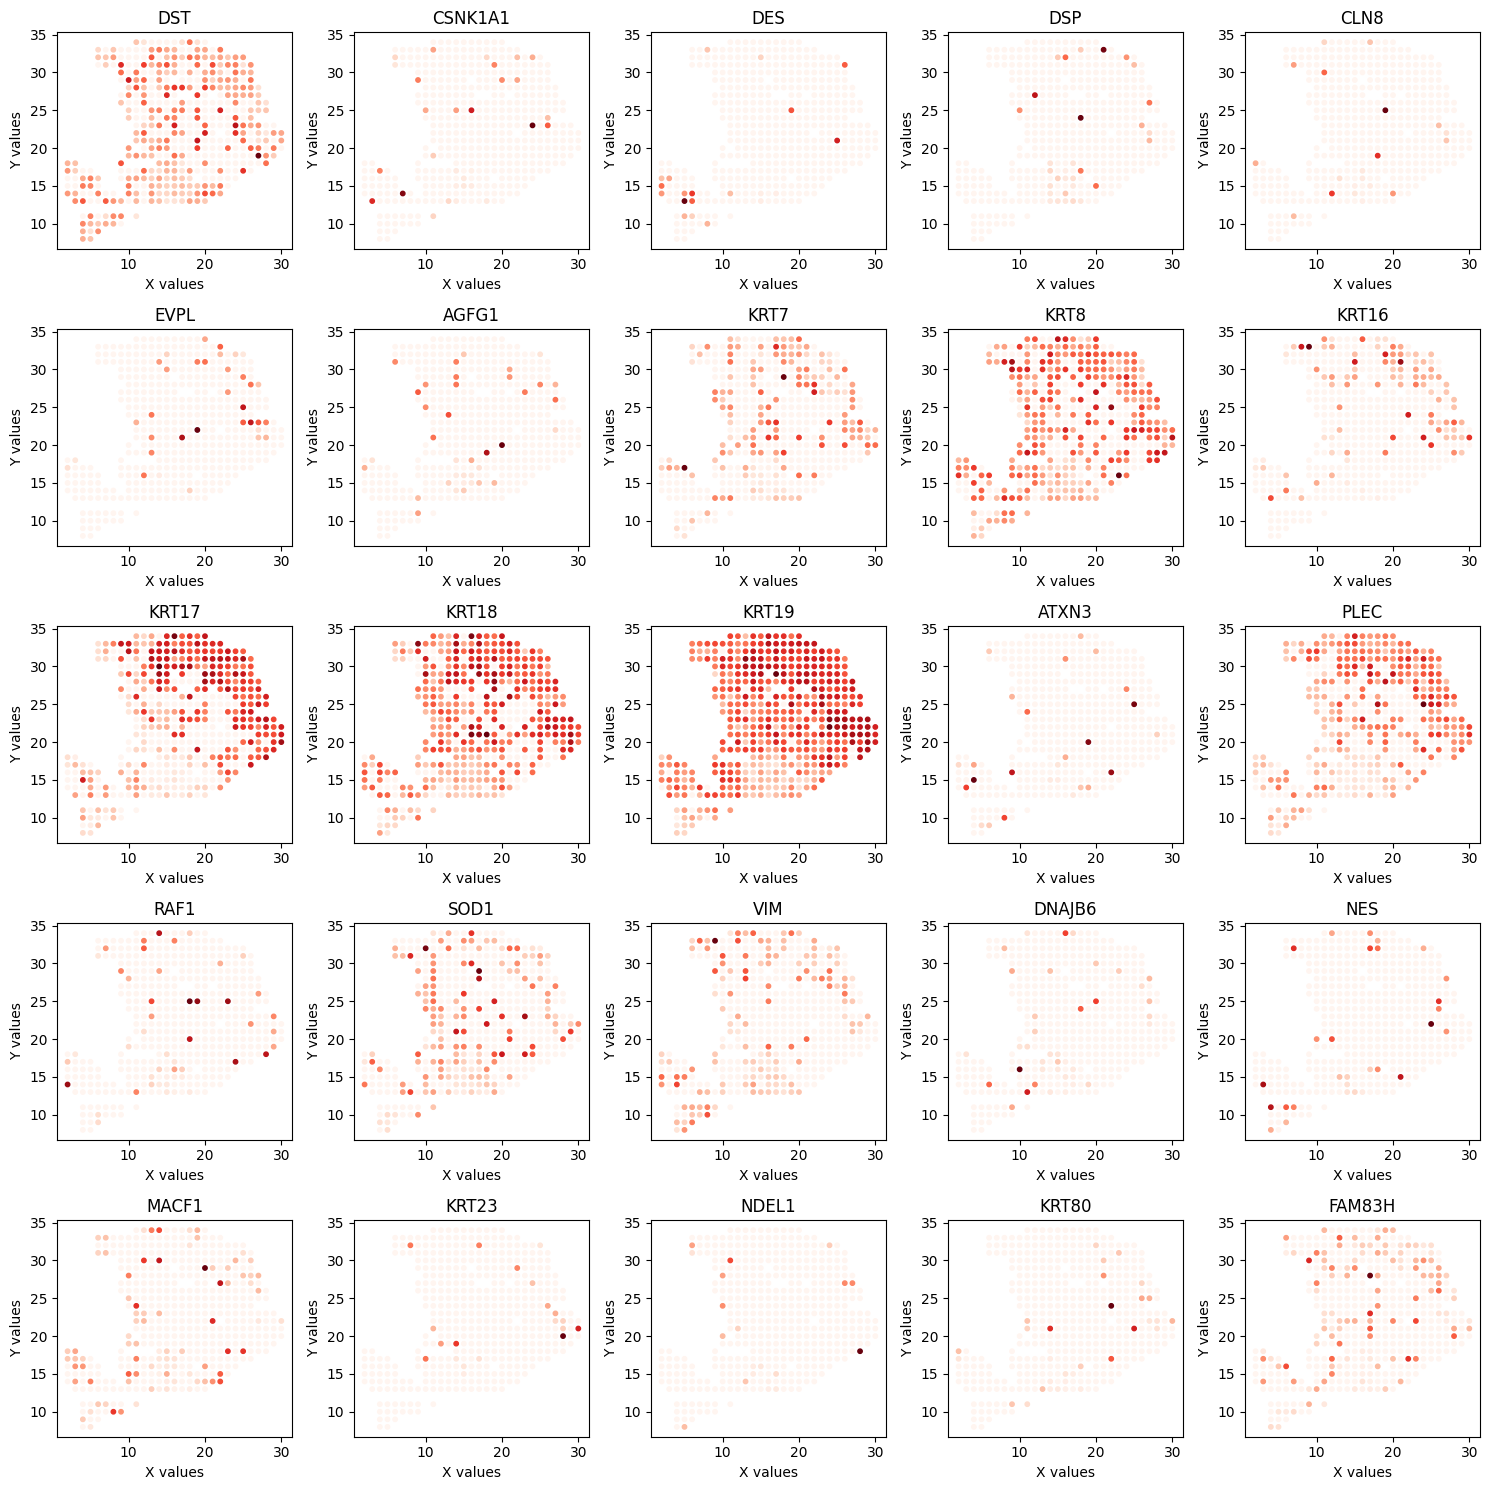

In [12]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))

axes = axes.flatten()

for i, ax in enumerate(axes):
    values_to_color = adata_data[:,gene_str[i]].X.flatten()
    ax.scatter(loc['x'].values, loc['y'].values, c=values_to_color, cmap='Reds', s=10)
    ax.set_title(f'{gene_str[i]}')
    ax.set_xlabel('X values')
    ax.set_ylabel('Y values')

plt.tight_layout()

plt.show()

## Pathway testing for the edge or inner part

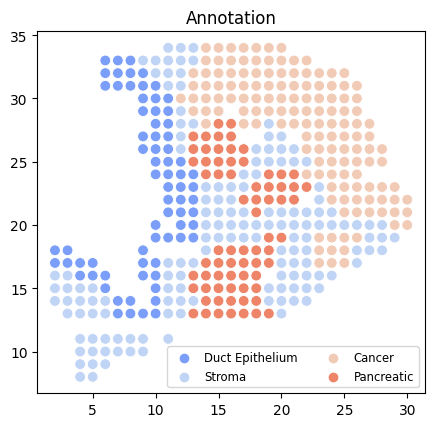

In [119]:
plt.figure(figsize=(5, 4.7),dpi = 100)
sns.scatterplot(data=info, x='x', y='y', hue='Region', palette='coolwarm', s=60)  # Change the palette as needed
plt.title('Annotation')
plt.xlabel('')
plt.ylabel('')

plt.legend(loc='lower center', bbox_to_anchor=(0.66, 0), ncol=2, fontsize='small')
plt.show()

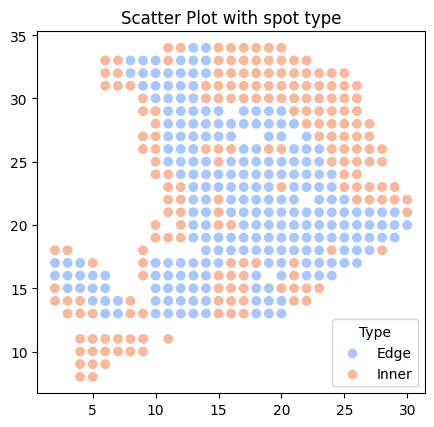

In [118]:
# Find edge nodes
edge = []

for i in range(len(info['Region'])):
    xi, yi = info['x'][i], info['y'][i]
    rule = (np.abs(info['x'] - xi) < 1.5) & (np.abs(info['y'] - yi) < 1.5)
    idx = np.where(rule)[0]
    neighbor_type = info['Region'].iloc[idx]
    if len(np.unique(neighbor_type)) == 1:
        edge.append('Inner') # 0
    else:
        edge.append('Edge')

# Add the 'edge' column to the DataFrame
info['Type'] = edge

# Plot the points with different colors based on the 'edge'
plt.figure(figsize=(5, 4.7),dpi=100)
sns.scatterplot(data=info, x='x', y='y', hue='Type', palette='coolwarm', s=60)
plt.title('Scatter Plot with spot type')
plt.xlabel('')
plt.ylabel('')

plt.show()

In [57]:
adata_data = sc.AnnData(Count.T)
adata_data.var_names = Count.index
adata_data.obs_names = Count.columns
adata_data.obs['celltype'] = info['Region'].values

sc.pp.filter_genes(adata_data, min_cells=20)
sc.pp.normalize_total(adata_data, inplace=True)
sc.pp.log1p(adata_data)

In [58]:
cancer_in_idx = info[(info['Region'] == 'Cancer') & (info['Type'] == 'Inner')].index.values
cancer_edge_idx = info[(info['Region'] == 'Cancer') & (info['Type'] == 'Edge')].index.values

data = adata_data.X

data_this = data[list(cancer_in_idx) + list(cancer_edge_idx),:]
non_zero_count = np.count_nonzero(data_this, axis=0)
data_this = data[:,non_zero_count>20]

print('in len:', len(cancer_in_idx))
print('out len:', len(cancer_edge_idx))

in len: 92
out len: 45


In [60]:
symbol = adata_data.var_names.values
symbol_sel = adata_data.var_names.values[non_zero_count>20]

In [61]:
pathway_df = find_pathway(symbol_sel, symbol)

[1] "The first element does not contain 'ENS'."


R[write to console]: 'select()' returned 1:many mapping between keys and columns

R[write to console]: 'select()' returned 1:many mapping between keys and columns



In [75]:
output_csv = 'PDAC_edge_example.csv'

pd.DataFrame(columns=['ID', 'name', 'n_gene', 'pval', 'dcov', 'dcor']).to_csv(output_csv, index=False)

for i in range(1,len(pathway_df)):
    this_pathway = i

    gene_str = pathway_df['name'][this_pathway]

    gene_number = pathway_df['Count'][this_pathway]

    if gene_number<500 and gene_number>10:

        gene_str = gene_str.strip("'")
        gene_str = gene_str.split(', ')
        gene_str = [item.replace('MICOS10-', '') for item in gene_str]
        gene_str = [item.replace('MMP24-AS1-', '') for item in gene_str]
        gene_str = [gene for gene in gene_str if gene in adata_data.var_names]

        gene_number = len(gene_str)

        # Assuming gene_str is defined and adata_data is your AnnData object
        data_subset = adata_data[:, gene_str].X

        # Check if the data is in a sparse matrix format
        if issparse(data_subset):
            data = data_subset.todense()
        else:
            data = data_subset

    data_in = data[cancer_in_idx,:]
    data_out = data[cancer_edge_idx,:]

    rpy2.robjects.numpy2ri.activate()

    ro.r.assign("data_in", data_in.T)
    ro.r.assign("data_out", data_out.T)

    rpy2.robjects.numpy2ri.activate()
    robjects.r(
               '''
                library(energy)
                x <- data_in
                y <- data_out

                set.seed(1)
                res <- dcov.test(x, y, R=199)

                pval <- res$p.value
                dcov <- res$estimates[1]
                dcor <- res$estimates[2]
               '''
               )
    #symbol = robjects.r['symbol']
    p_val = robjects.r['pval'][0]
    dcov = robjects.r['dcov'][0]
    dcor = robjects.r['dcor'][0]

    # Construct a DataFrame for the current iteration
    current_res = pd.DataFrame({'ID': [pathway_df['GOBPID'][i]],
                                'name': [pathway_df['Term'][i]],
                                'n_gene': [gene_number],
                                'pval': [p_val],
                                'dcov': [dcov],
                                'dcor': [dcor]})

    # Append the result of the current iteration to the CSV file
    current_res.to_csv(output_csv, mode='a', header=False, index=False)

In [80]:
path_res = pd.read_csv('PDAC_edge_example.csv')

path_res = path_res.sort_values(by='dcor', ascending=True)
path_res = path_res.reset_index(drop=True)

path_res.iloc[0:10,:]

,ID,name,n_gene,pval,dcov,dcor
0,GO:0042742,defense response to bacterium,45,1.000,0.000000,0.000000
1,GO:0007276,gamete generation,45,1.000,0.000000,0.000000
2,GO:0034599,cellular response to oxidative stress,45,1.000,0.000000,0.000000
3,GO:0006816,calcium ion transport,45,1.000,0.000000,0.000000
4,GO:0071559,response to transforming growth factor beta,45,1.000,0.000000,0.000000
5,GO:0002443,leukocyte mediated immunity,45,0.345,0.058452,0.082550
6,GO:0046034,ATP metabolic process,45,0.265,0.132371,0.118817
7,GO:0042327,positive regulation of phosphorylation,92,0.040,0.065716,0.125274
8,GO:0046700,heterocycle catabolic process,45,0.175,0.071713,0.142147
9,GO:0098916,anterograde trans-synaptic signaling,45,0.110,0.087387,0.161581


In [111]:
to_show_gene = ['CD74', 'SPINK1', 'ALDOA', 'BCAP31', 'RPS6', 'CALR']  #'CD74'

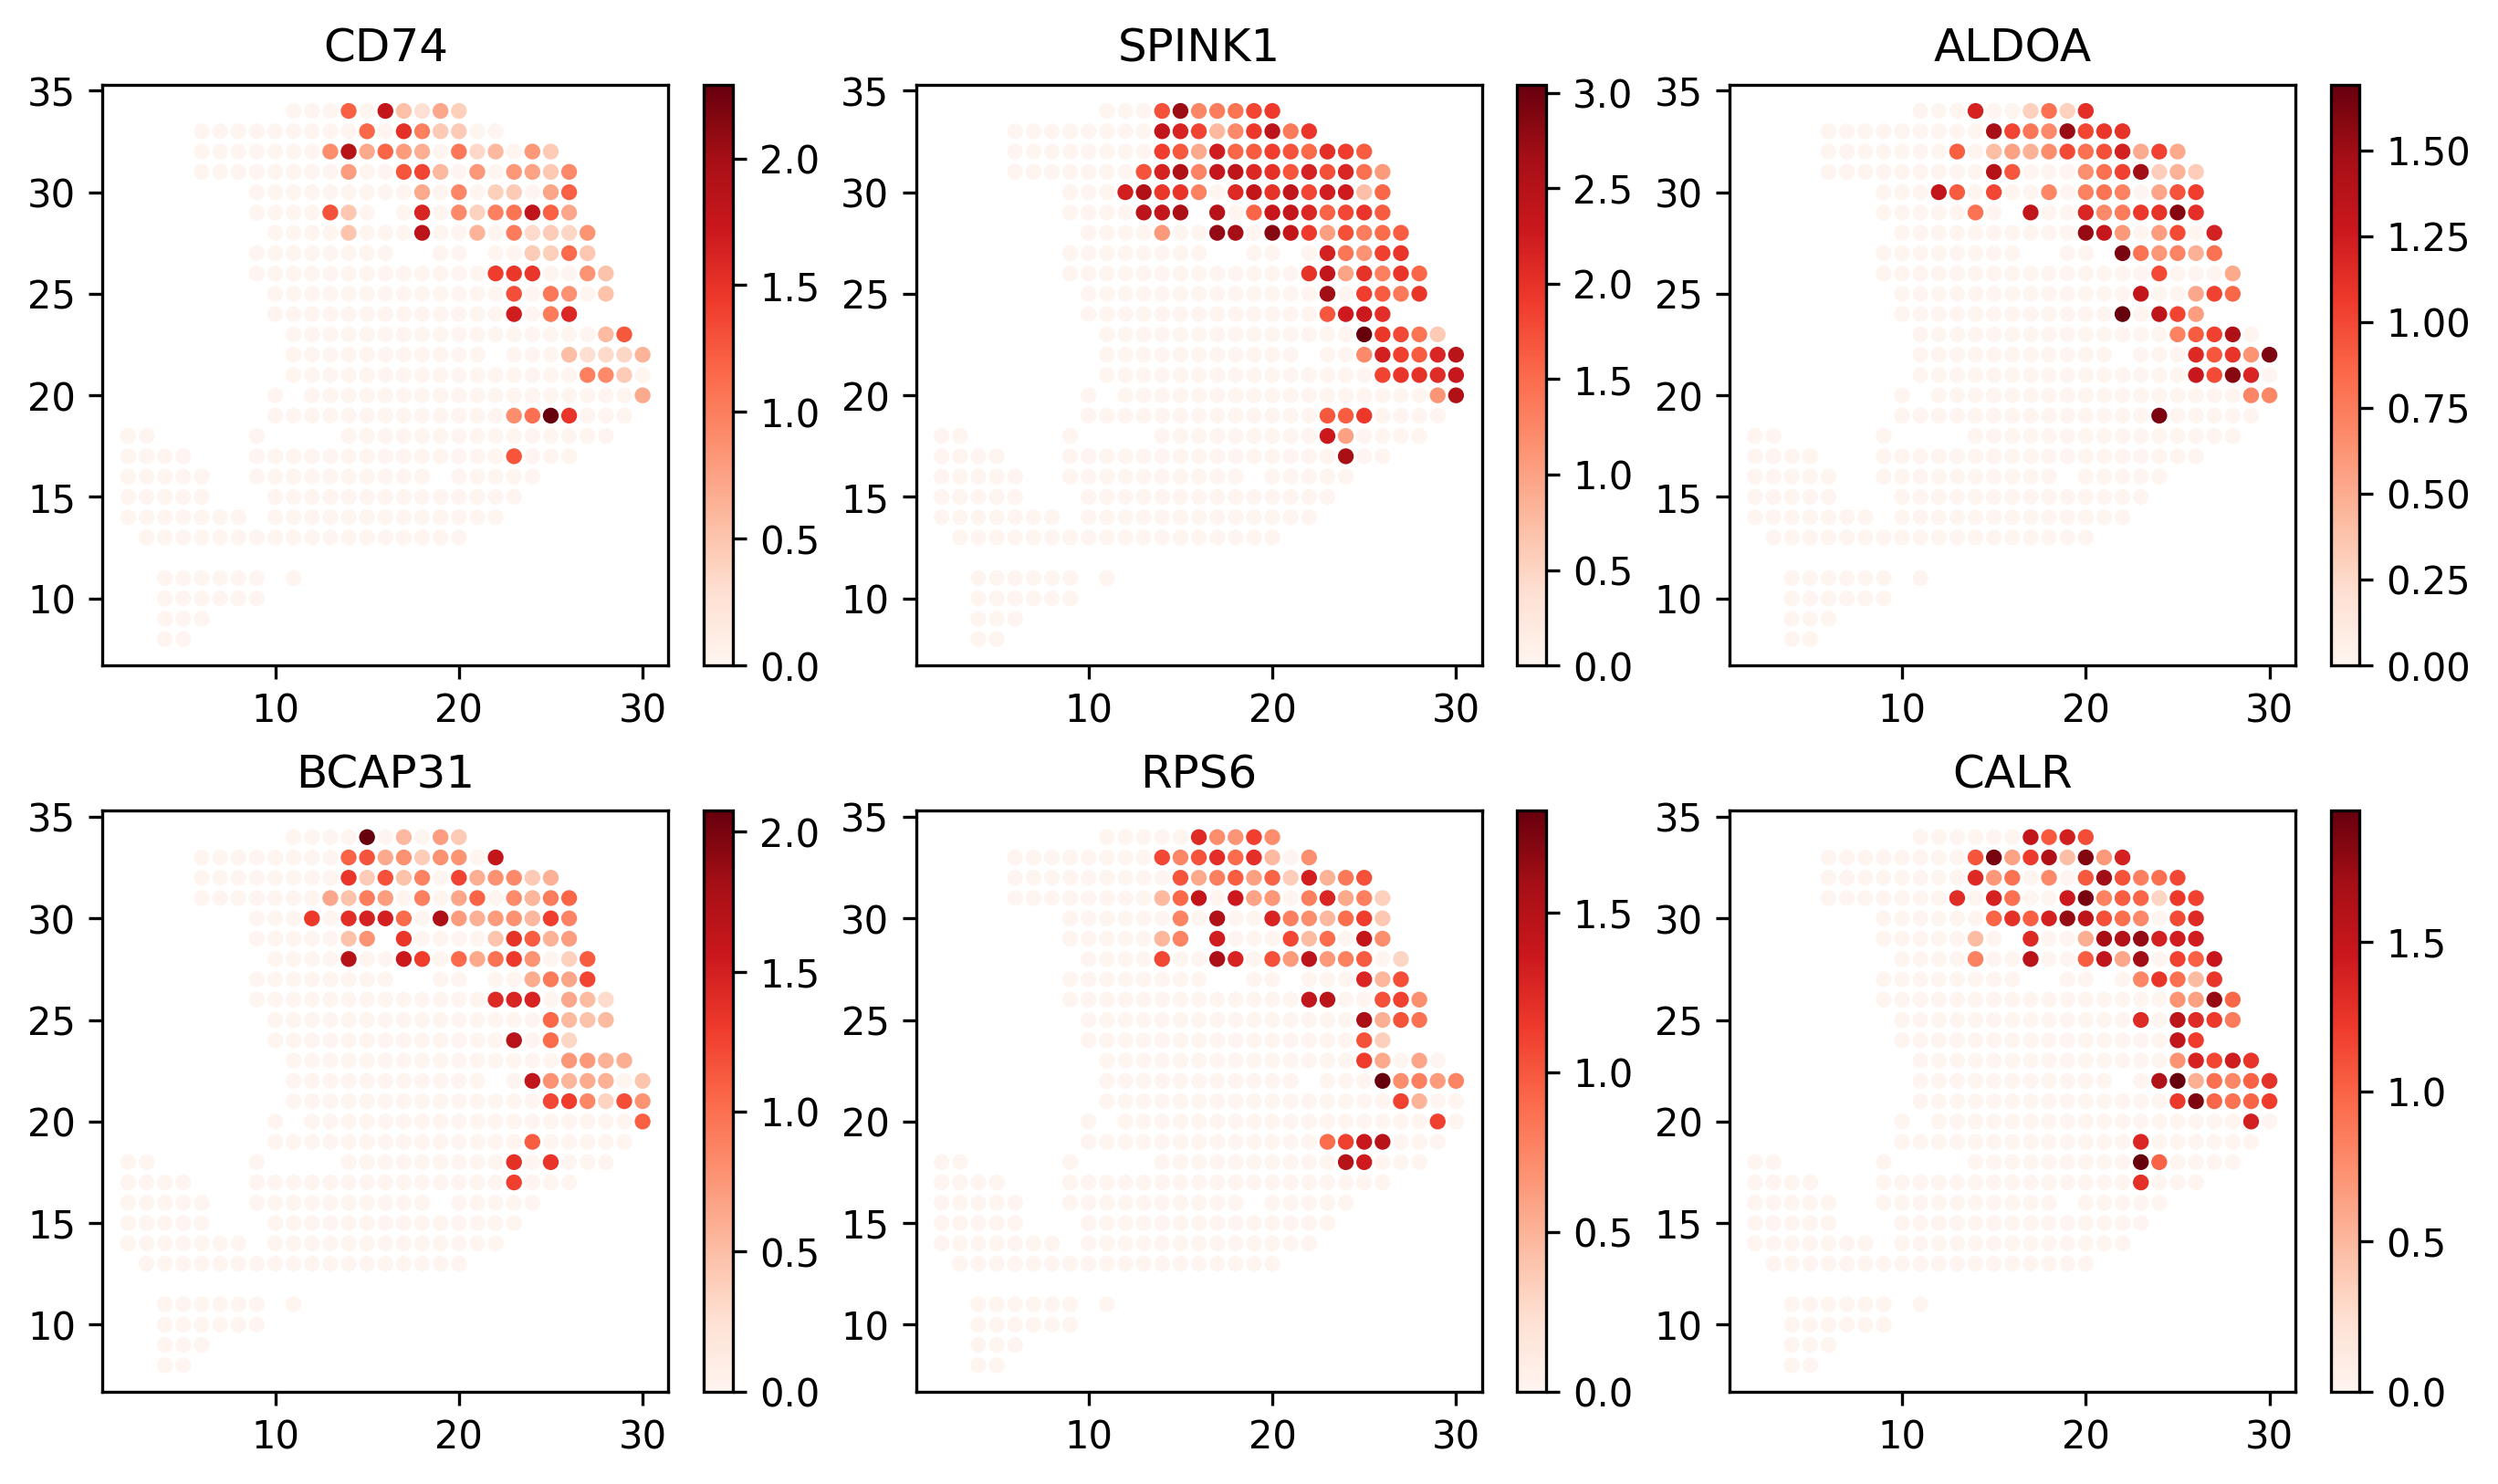

In [115]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(11, 6.2), dpi=300)

axes = axes.flatten()

for i, ax in enumerate(axes):
    values_to_color = adata_data[:, to_show_gene[i]].X.flatten()
    values_to_color = np.array(values_to_color)
    values_to_color[np.where(adata_data.obs['celltype'] != 'Cancer')[0]] = 0
    scatter = ax.scatter(info['x'], info['y'], c=values_to_color, cmap='Reds', s=10)
    ax.set_title(f'{to_show_gene[i]}')
    cbar = fig.colorbar(scatter, ax=ax)
    #cbar.set_label('Colorbar Label')  # Set the label for the colorbar

plt.subplots_adjust(wspace=0.15, hspace=0.25)  # Adjust these values as needed

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6.5), dpi=300)

axes = axes.flatten()

# Define a normalization for all subplots
norm = plt.Normalize(vmin=adata_data[:, to_show_gene].X.min(), vmax=adata_data[:, to_show_gene].X.max())

for i, ax in enumerate(axes):
    values_to_color = adata_data[:, to_show_gene[i]].X.flatten()
    values_to_color = np.array(values_to_color)
    values_to_color[np.where(adata_data.obs['celltype'] != 'Cancer')[0]] = 0
    scatter = ax.scatter(info['x'], info['y'], c=values_to_color, cmap='Reds', s=10, norm=norm)
    ax.set_title(f'{to_show_gene[i]}')

# Add a single colorbar for all subplots
cbar = fig.colorbar(scatter, ax=axes, shrink=0.5)  # Adjust shrink value as needed
#cbar.set_label('Colorbar Label')  # Set the label for the colorbar

#plt.subplots_adjust(wspace=0.15, hspace=0.4)  # Adjust these values as needed

plt.show()
